In [1]:
from ultralytics import YOLO
import torch
from torch.profiler import profile, record_function, ProfilerActivity

from matplotlib import pyplot as plt
import cv2

In [2]:
def plot_box(result):
    image = result.orig_img
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1.2
    fontColor = (0,0,255)
    thickness = 2
    lineType = 1 
    
    for idx, boxes in enumerate(result.boxes.xyxy):
        conf =  round(result.boxes.conf[idx].item(), 2)
        clas = result.names[result.boxes.cls[idx].item()]
        
        cv2.rectangle(image, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), color=(0, 0, 255), thickness=2)
        cv2.putText(image, f'{conf},{clas}', 
            (int(boxes[0]), int(boxes[1])), 
            font, 
            fontScale,
            fontColor,
            thickness,
            lineType)

    return image[:, :, ::-1]

# orig

In [3]:
def load_model(model_path):
    model = YOLO(model_path)
    return model

In [4]:
model = load_model('best_3000.pt')

In [5]:
im = cv2.imread('WIN_20240514_12_13_52_Pro.jpg')

In [6]:
res =  model.predict(im, verbose=False)

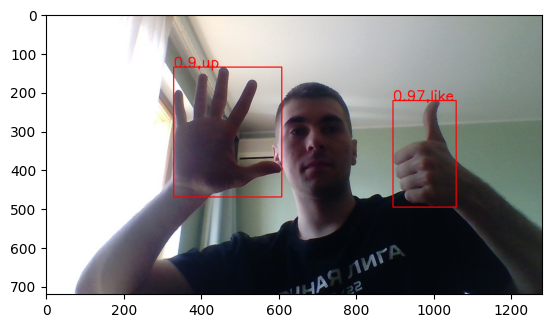

In [7]:
plt.imshow(plot_box(res[0]))

In [8]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model.predict(im, verbose=False)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        15.66%      13.501ms       100.00%      86.238ms      86.238ms             1  
                     aten::conv2d         0.36%     308.000us        44.60%      38.463ms     600.984us            64  
                aten::convolution         1.24%       1.066ms        44.06%      37.997ms     593.703us            64  
               aten::_convolution         0.58%     497.000us        43.83%      37.797ms     590.578us            64  
         aten::mkldnn_convolution        41.69%      35.956ms        42.22%      36.409ms     606.817us            60  
                      aten::silu_       

In [26]:
%%timeit
model.predict(im, verbose=False)

84.9 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Vino

In [17]:
ov_model = YOLO("weights/best_3000_openvino_model/", task='detect')

In [18]:
image = cv2.imread('WIN_20240514_12_13_52_Pro.jpg')

In [19]:
res_vino = ov_model.predict(image, verbose=False)

Loading weights\best_3000_openvino_model for OpenVINO inference...


In [27]:
%%timeit
ov_model.predict(image, verbose=False)

44.5 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


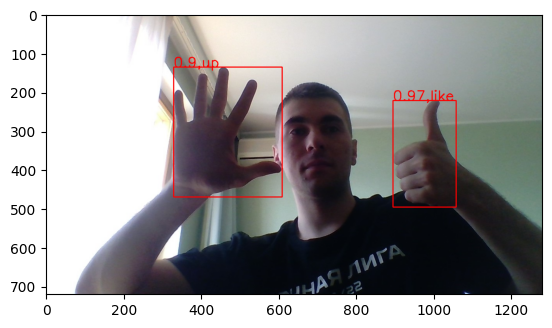

In [21]:
plt.imshow(plot_box(res_vino[0]))

In [23]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference_vino"):
        ov_model.predict(image, verbose=False)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
      model_inference_vino        95.95%      46.892ms       100.00%      48.871ms      48.871ms             1  
                  aten::to         0.05%      23.000us         2.01%     983.000us      37.808us            26  
            aten::_to_copy         0.15%      72.000us         1.97%     963.000us      68.786us            14  
               aten::copy_         1.82%     891.000us         1.82%     891.000us      31.821us            28  
                aten::div_         0.80%     392.000us         0.85%     415.000us     207.500us             2  
                aten::amax         0.24%     117.000us         0.25%     120.000us     120.000us